# 1. Computing Expected Branch Lengths

-- Alex Warwick Vesztrocy, November 2023

In this notebook we will compute the expected branch lengths, using a simple evolutionary model: the expected branch length is the relevant branch in the species tree, multipled by a family-specific rate. This is expressed as a system of equations, so that we can optimise the family-rates and species tree edge lengths, constrained by the observed branch lengths on the gene families.

We can then look at the distribution of the difference from the expected branch length, for each branch in the species tree. This gives us a method to identify the unexpectedly long branches, so that we can test the hypothesis of the Least Diverged Orthologue (LDO).

The next step is then to filter so that we only have edges over a duplication (single-hop only).

In [4]:
%matplotlib inline
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from lib.PantherParser import PantherTrees

In [ ]:
pt = PantherTrees(
     "./data/panther-18.0/trees/",
     taxonomy_fn="./data/panther-18.0/species_tree.nhx",
)

### Step 1 - load distances

In [3]:
df = pt.distances

 - Parsing families
[########################################] | 100% Completed | 16.67 s
 - Mapping edges


In [4]:
df

,fam_id,filter_edge,tail,fam_tail_idx,fam_tail_ev,head,fam_head_idx,fam_head_ev,length,over_duplication,path,edge
0,21731,False,Euteleostomi,0,SPECIATION,Tetrapoda,1,SPECIATION,0.344,False,[220],220.0
1,21731,False,Tetrapoda,1,SPECIATION,Amniota,2,SPECIATION,0.288,False,[184],184.0
2,21731,False,Amniota,2,SPECIATION,Theria,3,SPECIATION,0.327,False,"[34, 79]",NaN
3,21731,False,Theria,3,SPECIATION,Eutheria,5,SPECIATION,0.686,True,[48],48.0
4,21731,False,Eutheria,5,SPECIATION,Euarchontoglires,6,SPECIATION,0.088,False,[64],64.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3096023,47077,True,Chordata,2,SPECIATION,BRAFL,33,EXTANT_GENE,2.067,True,None,NaN
3096024,47077,True,Chordata,2,SPECIATION,BRAFL,34,EXTANT_GENE,2.067,True,None,NaN
3096025,47077,True,Chordata,2,SPECIATION,BRAFL,35,EXTANT_GENE,2.067,True,None,NaN
3096026,47077,False,Deuterostomia,1,SPECIATION,STRPU,36,EXTANT_GENE,0.606,False,[237],237.0


### 2 - Fit model

In [6]:
ret = pt.solve_rates(start=0)

2 7.217424687211427e-05 0.00023086364057656183 0.00048271139327954693
3 1.0466573349576791e-05 3.958938312420557e-05 0.0004824876631036876
4 4.480949761687114e-06 1.3520191974314422e-05 0.00048249228154545633
5 1.719320156357007e-06 5.103116565874366e-06 0.00048252052372158445
6 6.314785587768768e-07 1.977169833078385e-06 0.0004825445451469817
7 2.3120017433875262e-07 7.754406002868919e-07 0.00048256163232017794
8 8.618227798073974e-08 3.061325822839578e-07 0.00048257318034171924
9 3.2113227743657546e-08 1.2141085359296255e-07 0.0004825807343504011
10 1.2307080243800783e-08 4.8252758899636206e-08 0.00048258561570514524
11 4.670502207204663e-09 1.9265200656981563e-08 0.000482588786069652
12 1.807011762444688e-09 7.711338234628329e-09 0.00048259083903337525
13 6.962964649304126e-10 3.101548240458385e-09 0.00048259215266782153
14 2.9284641378524157e-10 1.2364984591783923e-09 0.00048259294208544183
15 1.0940781614010575e-10 4.971441036616397e-10 0.00048259350178587795


### 3 - Estimate the expected length of each branch

This is based on our basic evolutionary model.

In [7]:
# (uses the above solution cached in pt obj)
df['expected_length'] = pt.compute_expected_branch(df)

### 4 - Species tree

We can also map the estimated distances back onto the taxonomy.

In [8]:
pt.taxonomy.fit_distances(ret['taxonomy'])

In [9]:
nwk = pt.taxonomy.t.as_string('newick')

In [10]:
print(nwk)

(((((((((((((((((((((HUMAN:0.013,PANTR:0.021)'Homo-Pan':0.005,GORGO:0.024)Homininae:0.031,MACMU:0.041)Catarrhini:0.051,(MOUSE:0.045,RAT:0.061)Murinae:0.093)Euarchontoglires:0.024,(((BOVIN:0.081,PIG:0.074)Artiodactyla:0.027,HORSE:0.071)Perissodactyla:0.015,(FELCA:0.068,CANLF:0.069)Carnivora:0.026)Laurasiatheria:0.027)Eutheria:0.128,MONDO:0.19)Theria:0.071,ORNAN:0.188)Mammalia:0.097,(CHICK:0.193,ANOCA:0.254)Sauria:0.078)Amniota:0.129,XENTR:0.347)Tetrapoda:0.124,((ORYLA:0.307,DANRE:0.285)Teleostei:0.124,LEPOC:0.248)Neopterygii:0.157)Euteleostomi:0.521,CIOIN:0.861)'Craniata-Tunicata':0.077,BRAFL:0.784)Chordata:0.145,STRPU:0.863)Deuterostomia:0.2,((((CAEEL:0.267,CAEBR:0.278)Caenorhabditis:0.655,PRIPA:0.877)'Rhabditida-Chromadorea':0.631,((((DROME:0.68,ANOGA:0.596)Diptera:0.245,TRICA:0.632)Endopterygota:0.276,DAPPU:0.777)'Hexapoda-Crustacea':0.17,IXOSC:0.832)Arthropoda:0.154)Ecdysozoa:0.126,HELRO:1.01)Protostomia:0.148)Bilateria:0.327,NEMVE:0.916,TRIAD:0.939)Eumetazoa:0.466,MONBE:1.297)'Meta

In [11]:
with open('results/taxonomy_fit.nwk', 'wt') as fp:
    print(nwk, file=fp)

### 5 - Visualise the fitted system
Plot the fitted branch lengths / family scaling rate factors. We can then also look at the slowest / fastest evolving families.

In [12]:
!mkdir -p ./results/plots

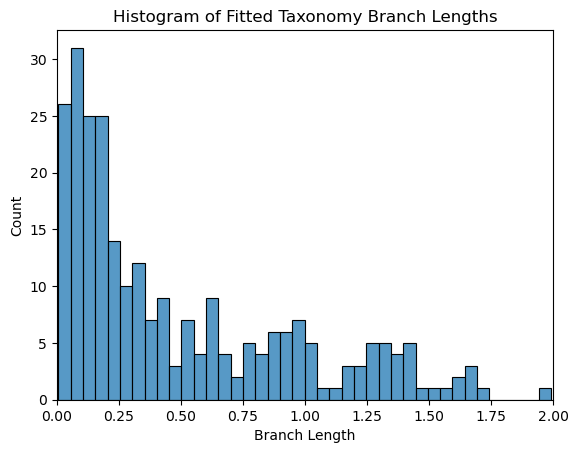

In [13]:
ax = sns.histplot(ret['taxonomy'], bins=40)
ax.set_title('Histogram of Fitted Taxonomy Branch Lengths')
ax.set_xlabel('Branch Length')
ax.set_xlim((0,2))

plt.savefig('results/plots/histogram_fitted_species_branchlengths.pdf', bbox_inches='tight')

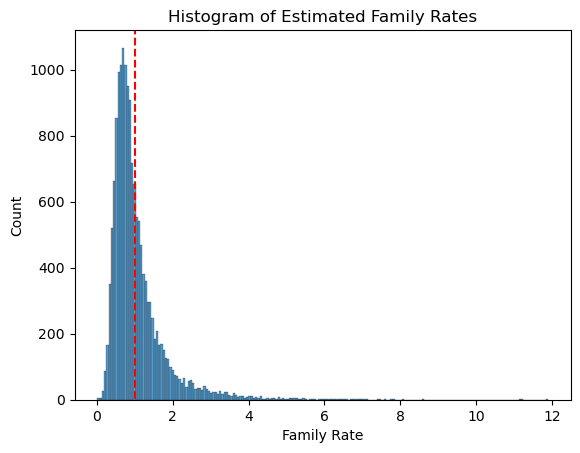

In [14]:
ax = sns.histplot(ret['rates'], bins=200)
ax.set_title('Histogram of family-specific factor')
ax.set_xlabel('Family Rate')
ylims = ax.get_ylim()
plt.vlines(1, ylims[0]-1000, ylims[1]+1000, color='red', linestyle='--')#, ymin=0, ymax=)
ax.set_ylim(*ylims)

plt.savefig('results/plots/histogram_estimate_famrates.svg', bbox_inches='tight')

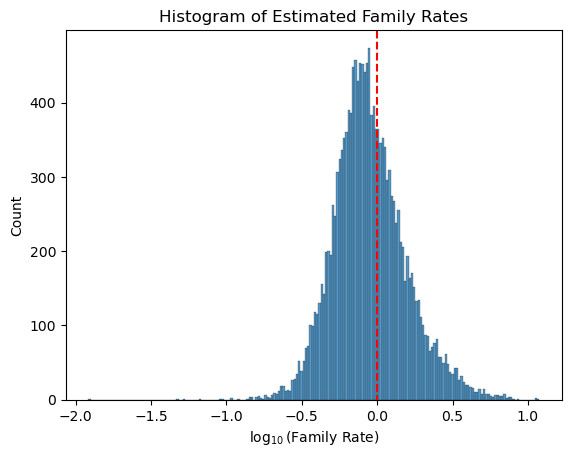

In [15]:
ax = sns.histplot(np.log10(ret['rates']), bins=200)
ax.set_title('Histogram of Estimated Family Rates')
ax.set_xlabel('$\log_{10}$(Family Rate)')
ylims = ax.get_ylim()
plt.vlines(0, ylims[0]-1000, ylims[1]+1000, color='red', linestyle='--')#, ymin=0, ymax=)
ax.set_ylim(*ylims)

plt.savefig('results/plots/histogram_estimate_famrates_LOG10.pdf', bbox_inches='tight')

Is there a bias in the number of edges in the gene tree vs the family scaling rate?

Look at the family scaling rate vs number of edges in model. (Note: edge in gene tree can correspond to more than one branch in the taxonomy)

In [16]:
from collections import Counter

c = Counter(df[~df.filter_edge].fam_id)

branch_counts = [c[i] for i in pt.matrices['family_membership'][1]]

Text(0, 0.5, 'No. Edges in Family')

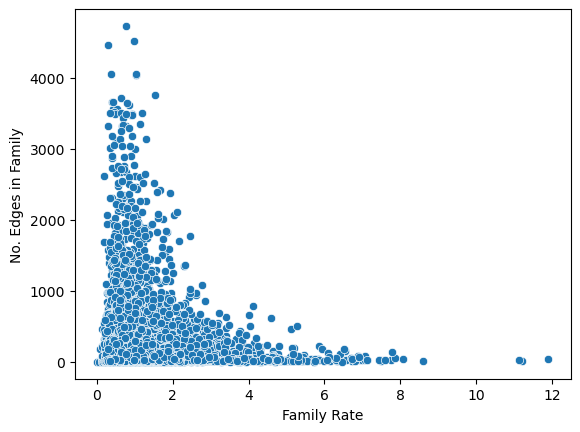

In [17]:
ax = sns.scatterplot(x=ret['rates'], y=branch_counts)
ax.set_xlabel('Family Rate')
ax.set_ylabel('No. Edges in Family')

Text(0, 0.5, 'No. Edges in Family')

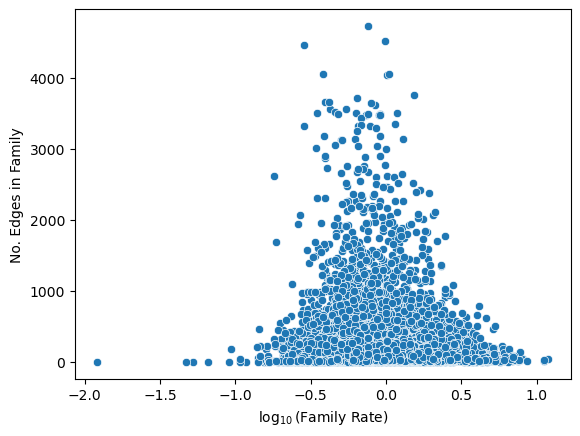

In [18]:
ax = sns.scatterplot(x=np.log10(ret['rates']), y=branch_counts)
ax.set_xlabel('$\log_{10}$(Family Rate)')
ax.set_ylabel('No. Edges in Family')

### 6 - Family Investigation

Get the slowest / fastest n and retreive their base SF description from the panther API.

In [19]:
from functools import lru_cache
from property_manager import lazy_property
import json
import pandas as pd
import urllib


class PantherAPI(object):
    BASE_URL = 'http://pantherdb.org/services/oai/pantherdb'
    @staticmethod
    def _get_json(url):
        resp = urllib.request.urlopen(url)
        if resp.getcode() == 200:
            return json.loads(resp.read())
        else:
            raise ValueError('API error {}'.format(resp.getcode()))
    
    @lru_cache(1000)
    def get_fam_info(self, fam_id):
        url = f'{self.BASE_URL}/treeinfo?family=PTHR{fam_id}'
        return _get_json(url)

    def get_fam_name(self, fam_id):
        info = self.get_fam_info(fam_id)
        return info['search']['tree_topology']['annotation_node']['sf_name']
    
    @lazy_property
    def fam_names(self):
        url = f'{self.BASE_URL}/supportedpantherfamilies?startIndex='
        i = 1
        fams = []
        pbar = tqdm()
        while True:
            z = self._get_json(f'{url}{i}')
            assert z['search']['start_index'] == i
            fams += z['search']['panther_family_subfam_list']['family']
            i = (z['search']['end_index'] + 1)
            pbar.update()
            if i > z['search']['number_of_families']:
                break
        pbar.close()
        return pd.DataFrame(fams)

In [20]:
pantherdb = PantherAPI()

In [21]:
names = pantherdb.fam_names

0it [00:00, ?it/s]

In [22]:
names['fam_id'] = names['family_id'].apply(lambda x: int(x[4:]))
branch_count = Counter(df[~df.filter_edge].fam_id)
names['branch_count'] = names['fam_id'].apply(lambda x: branch_count[x])
names = names.set_index('fam_id')

In [23]:
i2f = np.array(pt.matrices['family_rates'][2])
order = np.argsort(ret['rates'])
i2f[order]

array([39767, 33246, 33211, ..., 37553, 33026, 15438])

In [24]:
names = names.loc[i2f[order]]
names['rate'] = ret['rates'][order]

In [25]:
names.sort_values('rate', inplace=True)

In [26]:
!mkdir -p results/tables

names.to_csv('results/tables/fitted_family_info.tsv', sep='\t', index=False)

<Axes: >

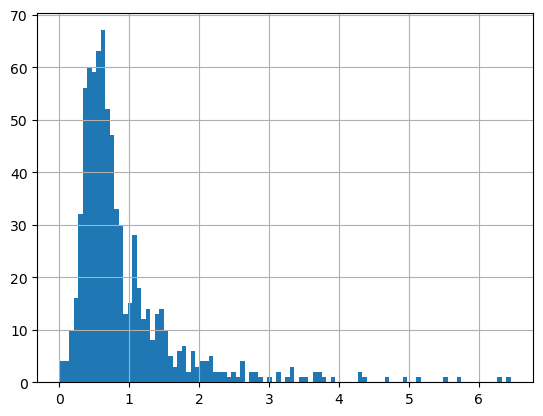

In [27]:
names[names.branch_count < 10].rate.hist(bins=100)

<Axes: >

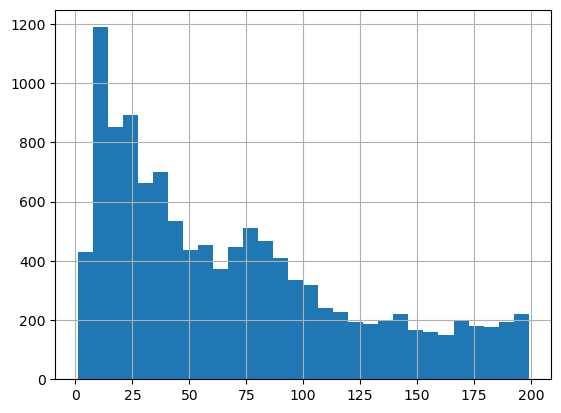

In [28]:
names.branch_count[names.branch_count < 200].hist(bins=30)

In [29]:
(names.branch_count < 10).sum()

767

In [30]:
(names.branch_count >= 10).sum()

14895

### 7 - Redo the analysis, excluding families that have fewer than 10 "valid" edges

In [31]:
# reset matrices (cached)
del pt.matrices

In [32]:
to_remove = {f for (f, c) in branch_count.items() if c < 10}

In [33]:
ret_remove_under10 = pt.solve_rates(start=0)

2 7.217424687211427e-05 0.00023086364057656183 0.00048271139327954693
3 1.0466573349576791e-05 3.958938312420557e-05 0.0004824876631036876
4 4.480949761687114e-06 1.3520191974314422e-05 0.00048249228154545633
5 1.719320156357007e-06 5.103116565874366e-06 0.00048252052372158445
6 6.314785587768768e-07 1.977169833078385e-06 0.0004825445451469817
7 2.3120017433875262e-07 7.754406002868919e-07 0.00048256163232017794
8 8.618227798073974e-08 3.061325822839578e-07 0.00048257318034171924
9 3.2113227743657546e-08 1.2141085359296255e-07 0.0004825807343504011
10 1.2307080243800783e-08 4.8252758899636206e-08 0.00048258561570514524
11 4.670502207204663e-09 1.9265200656981563e-08 0.000482588786069652
12 1.807011762444688e-09 7.711338234628329e-09 0.00048259083903337525
13 6.962964649304126e-10 3.101548240458385e-09 0.00048259215266782153
14 2.9284641378524157e-10 1.2364984591783923e-09 0.00048259294208544183
15 1.0940781614010575e-10 4.971441036616397e-10 0.00048259350178587795


In [34]:
df_remove_under10 = df.copy()

In [35]:
f = df_remove_under10['filter_edge'] | df_remove_under10['fam_id'].isin(to_remove)
df_remove_under10['filter_edge'] = f
df_remove_under10['expected_length1'] = pt.compute_expected_branch(df_remove_under10)

In [36]:
from scipy.stats import linregress

def diff(x, y):
    slope, intercept, r, p, sterr = linregress(x=x, y=y)
    total_abs_diff = sum(abs(y-x))
    print('y=ax+b', f'a={slope}', f'b={intercept}')
    print('total abs diff', total_abs_diff)

In [37]:
diff(df[~f]['expected_length'],df_remove_under10[~f]['expected_length'])

y=ax+b a=1.0 b=0.0
total abs diff 0.0


### Saving Results

In [38]:
df.to_csv('results/expected_branches_pthr18.tsv.gz', sep='\t', index=False)

Also print the UniProt entry IDs for all the entries in PANTHER families, so that we can get the UniProt <-> Ensembl mapping.

In [39]:
import itertools

uniprot_ids = set(map(lambda x: x['UniProtKB'],
                      itertools.chain(*map(lambda x: x.genes.values(),
                                           pt.iter_fams()))))

For each family:   0%|          | 0/15693 [00:00<?, ?it/s]

In [40]:
with open('results/pthr18_all_uniprot_ids.txt', 'wt') as fp:
    for x in sorted(uniprot_ids):  #pt.uniprot_ids:
        print(x, file=fp)

### Analysis for paper

In [41]:
bins=[[0,0.5],[0.5,1]]

In [42]:
names['rate'] > 1


fam_id
39767    False
33246    False
33211    False
33339    False
40866    False
         ...  
46793     True
37874     True
37553     True
33026     True
15438     True
Name: rate, Length: 15662, dtype: bool

<Axes: xlabel='rate', ylabel='Count'>

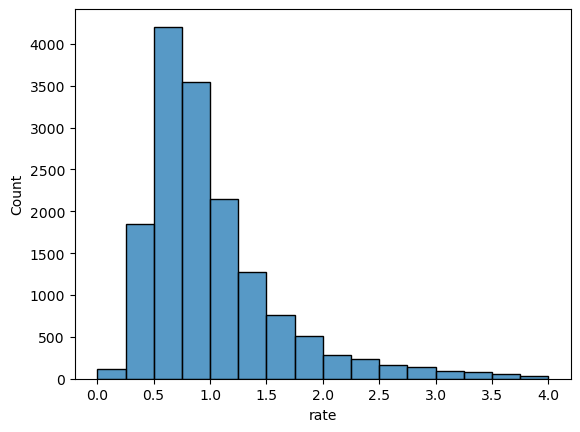

In [43]:
sns.histplot(names['rate'], bins=np.arange(0,4.25,0.25))#0,0.25,0.5,0.75,1,1.25,1.5,2,3,4])#,np.max(names['rate'])])

/tmp/ipykernel_5640/374154649.py:9: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15662.
  stat, p = shapiro(data)


Shapiro-Wilk Test: W=0.7158637751488727, p=2.64727826198435e-95
D'Agostino-Pearson Test: K2=11802.872361887117, p=0.0
Data does not follow a normal distribution (reject H0)

Check log normality..
Shapiro-Wilk Test: W=0.9853765218292231, p=5.902978899896661e-37
D'Agostino-Pearson Test: K2=697.3028233211721, p=3.824862330133839e-152
Data does not follow a normal distribution (reject H0)



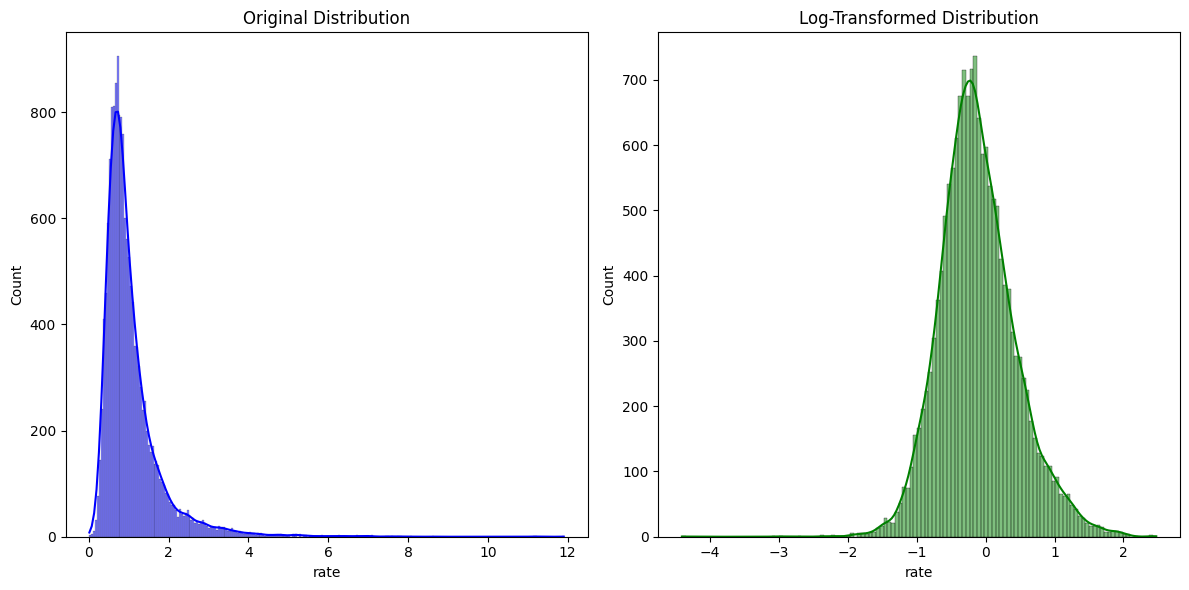

count    15662.000000
mean         1.060400
std          0.762319
min          0.012141
25%          0.622209
50%          0.852734
75%          1.232367
max         11.903988
Name: rate, dtype: float64
Mean: 1.0604004172936188
Standard Deviation: 0.7622950012018598
Coefficient of Variation: 71.89%
Z-scores: 0        -1.375137
1        -1.329769
2        -1.322873
3        -1.304953
4        -1.272458
           ...    
15657     9.214113
15658     9.890659
15659    13.217233
15660    13.316695
15661    14.224923
Name: rate, Length: 15662, dtype: float64


In [29]:
#### Stats of the family-specific factor distribution

import pandas as pd
from scipy.stats import shapiro, normaltest


def check_normality(data, alpha=0.05):
    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f'Shapiro-Wilk Test: W={stat}, p={p}')
    
    # D'Agostino and Pearson's Test
    stat, p = normaltest(data)
    print(f'D\'Agostino-Pearson Test: K2={stat}, p={p}')
    
    if p > alpha:
        print("Data follows a normal distribution (fail to reject H0)\n")
    else:
        print("Data does not follow a normal distribution (reject H0)\n")

def check_log_normality(data, alpha=0.05):
    log_data = np.log(data[data > 0])  # Apply log transformation, filtering out zero and negative values
    check_normality(log_data, alpha)

def plot_distributions(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original distribution
    sns.histplot(data, kde=True, ax=axes[0], color='blue')
    axes[0].set_title("Original Distribution")

    # Plot log-transformed distribution (removing non-positive values)
    sns.histplot(np.log(data[data > 0]), kde=True, ax=axes[1], color='green')
    axes[1].set_title("Log-Transformed Distribution")

    plt.tight_layout()
    plt.show()


### Family rate
inFile = 'results/tables/Final_tables/Supplementary_Table_4.tsv'
df = pd.read_csv(inFile, sep='\t')
data = df['rate']
# data = data[data < 2]
check_normality(data)
print('Check log normality..')
check_log_normality(data)
plot_distributions(data)
plt.show()

print(data.describe(include='all')) 

mean = np.mean(data)
std_dev = np.std(data)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
cv = (std_dev / mean) * 100
print(f"Coefficient of Variation: {cv:.2f}%") ## less than 10% indicate low dispersion
z_scores = (data - mean) / std_dev
print("Z-scores:", z_scores)

